In [1]:
import numpy as np
import pandas as pd
import os
import xgboost

from sklearn import ensemble, cross_validation, metrics
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV

import sys
sys.path.append('/Users/j.gonzalez/Documents/GitWorkspace/core/common/python')
# sys.path.append('../src')
sys.path.append('/Users/j.gonzalez/Desktop/PythonExperiments/PTBNewModel/src')
#sys.path.append('/Users/j.gonzalez/Desktop/PythonExperiments/PTBNewModel/cids')
import cx_Oracle
import configparser
import itertools
import ast

from cids.plotting import plot_auc
from cids.plotting import plot_precision_recall_curve
from cids.plotting import calculate_metrics

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#from IPython.display import clear_output
#clear_output()

In [2]:
from data import make_dataset as md
from preprocessing import preprocess as pp
from models import train_model as tm
from utils import plot_corr_heatmap, plot_roc_curve, plot_learning_curve, plot_confusion_matrix

In [3]:
import importlib
tm = importlib.reload(tm)

In [ ]:
#query = open('/Users/j.gonzalez/Desktop/PythonExperiments/RandomForestXboost/retention_predictor-master/sql/TRASH_RP_NEWTRAIN.sql', 'r').read()

In [4]:
query = """SELECT A.ACCOUNT_ID,
          A.ACCOUNT_NM,
          A.ACCOUNT_INDUSTRY_NM,
          A.EMPLOYEE_COUNT,
          FLOOR (LOG (2, 1 + CASE WHEN A.AGE_IN_DAYS >= 0 THEN A.AGE_IN_DAYS  / 182.5 ELSE 0 END)) AS LOGACTIVEAGE,
          A.AOV_BAND_WO_FNDTN AS AOV_BAND,
          A.SUPPORT_LEVEL_NM,
          --A.LIC_UTIL_SFDC,
          A.LIC_NUM_SFDC,
          A.LIC_NUM_USR_SFDC,
          A.LIC_NUM_USR_SFDC_14D,
          A.LIC_UTIL_OEM_ADJ_CUST,
          A.LIC_TLP_14D_SFDC,
          A.LIC_TLP_14D_CUST,
          A.LOG_DIST_CAMPAIGNS_USRS,
          A.LOG_DIST_EVENTS_UI_USRS,
          A.LOG_DIST_TASKS_UI_USRS,
          A.LOG_DIST_CUST_OBJ_UI_USRS,
          A.LOG_TOT_RPT_DSHBRD_VWS_PR_USR,
          A.LOG_DIST_DSHBRD_USR_VIEWS,
          A.LOG_DIST_QUOTES_UI_USRS,
          A.LOG_DIST_OPPTY_USRS,
          A.LOG_DIST_CASES_FEED_USRS,
          A.LOG_DIST_ENTITLEMENTS_UI_USRS,
          A.LOG_DIST_CASES_UI_USRS,
          A.LOG_DIST_SERVICE_CONSOLE_USRS,
          A.LOG_DIST_CASES_API_USRS,
          A.LOG_DIST_SOLUTIONS_UI_USRS,
          A.LOG_DIST_KNWLDG_SEARCH_USRS,
          A.LOG_DIST_CTI_USRS,
          A.LOG_DIST_SOAP_API_USRS,
          A.ORG_OPPT_SHARING_RULES_NUM,
          A.ORG_OPPTS_NUM,
          A.ORG_LEADS_PER_USER_NUM,
          A.ORG_LEADS_NUM,
          A.ORG_PRODUCTS_NUM,
          A.ORG_WORKFLOW_RULES_NUM,
          A.ORG_CUSTOM_APPS_NUM,
          A.ORG_ACCTS_NUM,
          A.ORG_CONTACTS_NUM,
          A.ORG_ACTIVITIES_NUM,
          A.ORG_CUSTOM_OBJECT_RECORDS_NUM,
          A.ORG_CASE_QUEUES_NUM,
          A.ORG_CASE_REC_TYPES_NUM,
          A.ORG_CASE_SHARING_RULES_NUM,
          A.ORG_CASES_NUM,
          A.ORG_SOLUTIONS_NUM,
          A.ORG_APEX_LOC_WRITTEN,
          A.CR_SETUP,
          A.CO_PHONE,
          A.CO_CHAT,
          A.CS_OOS,
          A.M_ESC_COMM_BIN_CNT,
          A.SLA1_MISS_CNT,
          A.NUM_MNTH_KA,
          A.NUM_MNTH_TRAIL,
          A.NUM_MNTH_VIDEO,
          A.NUM_MNTH_COMMUNITY,
          A.NUM_MNTH_WEBINAR,
          A.NUM_MNTH_CSR,
          A.LOW_CSAT_CASES_PCT,
          A.TOTAL_ACV,
          A.OPENPIPE_FTM,
          A.PIPEGEN_TTM,
          A.LOSTPIPE_TTM,
          A.GROWTH_PERCENTAGE_TTM,
          A.WIN_PERCENTAGE_TTM,
          A.ATTRITION_PERCENTAGE_TTM,
          A.TOTAL_OPTIES,
         -- A.RED_ACCOUNTS,
         -- A.RED_ACCOUNTS_OPEN_LAST12M,
          B.FLAG AS PTBFLAG
FROM CIDM_BETA.PTB_METRICS_TBL A  
INNER JOIN JGONZALEZ.PTB_SUCCESS_CLOUD_TARGET B
ON A.SNAPSHOT_DT = B.STARTDATE -- We take usage and other metrics at the start date 
     AND A.ACCOUNT_ID = B.ACCOUNT_ID
WHERE MODEL_NAME = 'Advisory'""" 

In [5]:
def fetchDBCredentials(dbcred_file):
    """
       Read database access credentials from the file in $HOME/.dbuser.cred
    """
    #Read database credentials from user supplied file
    conf = configparser.ConfigParser()
    conf.read(dbcred_file)
    #host, port, user, database, password
    host = conf.get('database_creds','host')
    port = conf.get('database_creds','port')
    user = conf.get('database_creds','user')
    database = conf.get('database_creds','database')
    password = conf.get('database_creds','password')
    return {'USER':user,'PASSWORD':password,'DATABASE':database,'HOST':host,'PORT':port}

USER_CRED_FILE = os.path.join(os.path.expanduser('~'), '.dbuser.cred')

con = cx_Oracle.connect('''{USER}/{PASSWORD}@{HOST}:{PORT}/{DATABASE}'''.format(
                **fetchDBCredentials(USER_CRED_FILE)
            ))

df = pd.read_sql(query, con)
con.close()

In [6]:
#df = df[df['AOV_BAND'].isin (['($50K-100K]','($100K-200K]'])]
#df = df[df['RENEWALWITHINANCHORYEAR'] == 1]
import inspect
lines = inspect.getsourcelines(plot_confusion_matrix)
print("".join(lines[0]))


def plot_confusion_matrix(con_m, title='Confusion matrix', cmap=pyplot.cm.OrRd_r):
    from matplotlib import pyplot as plt
    import numpy as np
    cm = con_m
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(cm))
    plt.xticks(tick_marks, rotation=0)
    plt.yticks(tick_marks)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    for x in range(2):
        for y in range(2):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')
    return plt



In [7]:
df.head()

,ACCOUNT_ID,ACCOUNT_NM,ACCOUNT_INDUSTRY_NM,EMPLOYEE_COUNT,LOGACTIVEAGE,AOV_BAND,SUPPORT_LEVEL_NM,LIC_NUM_SFDC,LIC_NUM_USR_SFDC,LIC_NUM_USR_SFDC_14D,...,LOW_CSAT_CASES_PCT,TOTAL_ACV,OPENPIPE_FTM,PIPEGEN_TTM,LOSTPIPE_TTM,GROWTH_PERCENTAGE_TTM,WIN_PERCENTAGE_TTM,ATTRITION_PERCENTAGE_TTM,TOTAL_OPTIES,PTBFLAG
0,0013000000FdrVJ,Loftware,High Tech,88.0,4,$200K-600K,Premier,175.0,86.0,81.0,...,0.00,5077.07,8400.00,35977.06,30900.00,0.03,0.14,0.00,4.0,0
1,00100000001ZjzK,ZOLL Medical Corporation,Healthcare & Life Sciences,1574.0,3,$600K-1M,Premier,682.0,672.0,492.0,...,0.00,96933.46,141492.00,245385.46,30960.00,0.14,0.76,0.00,7.0,0
2,0013000000Fdp5Z,"Cynosure, Inc.",Healthcare & Life Sciences,857.0,3,$600K-1M,Premier,458.0,326.0,208.0,...,0.00,263538.79,748468.72,1033099.45,205103.80,0.36,0.56,0.64,15.0,0
3,0013000000Ilqn4,ProSiebenSat.1 Applications GmbH,Other,988.0,4,$600K-1M,Premier,973.0,713.0,415.0,...,4.55,235664.18,333072.00,297872.18,0.00,0.34,1.00,0.00,3.0,0
4,00130000000YGhe,ForeScout Technologies Inc.,High Tech,500.0,4,$1M-5M,Premier,630.0,571.0,461.0,...,0.87,280235.84,624160.48,604935.50,87330.57,0.35,0.76,0.27,5.0,0


In [8]:
df.dtypes

ACCOUNT_ID                        object
ACCOUNT_NM                        object
ACCOUNT_INDUSTRY_NM               object
EMPLOYEE_COUNT                   float64
LOGACTIVEAGE                       int64
AOV_BAND                          object
SUPPORT_LEVEL_NM                  object
LIC_NUM_SFDC                     float64
LIC_NUM_USR_SFDC                 float64
LIC_NUM_USR_SFDC_14D             float64
LIC_UTIL_OEM_ADJ_CUST            float64
LIC_TLP_14D_SFDC                 float64
LIC_TLP_14D_CUST                 float64
LOG_DIST_CAMPAIGNS_USRS          float64
LOG_DIST_EVENTS_UI_USRS          float64
LOG_DIST_TASKS_UI_USRS           float64
LOG_DIST_CUST_OBJ_UI_USRS        float64
LOG_TOT_RPT_DSHBRD_VWS_PR_USR    float64
LOG_DIST_DSHBRD_USR_VIEWS        float64
LOG_DIST_QUOTES_UI_USRS          float64
LOG_DIST_OPPTY_USRS              float64
LOG_DIST_CASES_FEED_USRS         float64
LOG_DIST_ENTITLEMENTS_UI_USRS    float64
LOG_DIST_CASES_UI_USRS           float64
LOG_DIST_SERVICE

In [9]:
#df = tm.parse_data(query, printing = True)
df, variables = tm.parse_data(df, printing = True)

== DATA PARSING ==
Data loaded from EDW
Time: 0 s, Shape: (11404, 69)

Columns with nulls -- null count
Series([], dtype: int64)

FLAG Count by AOV Band
AOV_BAND    FLAG
$1-1K       0         36
$100K-200K  0       1566
            1         13
$10K-50K    0        257
            1          6
$10M-25M    0         30
            1         16
$1K-10K     0         86
            1          6
$1M-5M      0       1519
            1        156
$200K-600K  0       5504
            1         85
$25M+       0          2
            1          1
$50K-100K   0        376
            1          6
$5M-10M     0         81
            1         29
$600K-1M    0       1448
            1         46
0-1$        0        129
            1          6
dtype: int64

== DONE DATA PARSING ==
Final Time: 0 s, Final Shape: (11404, 100)


In [10]:
model = ensemble.RandomForestClassifier(
    n_estimators = 1000,
    max_depth = 10,
    min_samples_leaf = 5,
    class_weight = "balanced",
    random_state = 72
)

In [ ]:
#ml_metrics = tm.basic_train_model(df[variables], model, printing=True)

In [11]:
#cvariables.append('FLAG')
X, y, feature_names = tm.sklearn_from_pandas(df[variables])

index = np.arange(X.shape[0])
X_train, X_test, y_train, y_test, index_training, index_test = \
cross_validation.train_test_split(X,
                                  y,
                                  index,
                                  test_size=0.3,
                                  random_state=123,
                                  stratify=y)

In [13]:
# To access the test index in the dataframe, just to give some visual check to the data
df.iloc[index_test].head()

,ACCOUNT_ID,ACCOUNT_NM,ACCOUNT_INDUSTRY_NM,EMPLOYEE_COUNT,LOGACTIVEAGE,AOV_BAND,SUPPORT_LEVEL_NM,LIC_NUM_SFDC,LIC_NUM_USR_SFDC,LIC_NUM_USR_SFDC_14D,...,AOV_BAND[T.$200K-600K],AOV_BAND[T.$25M+],AOV_BAND[T.$50K-100K],AOV_BAND[T.$5M-10M],AOV_BAND[T.$600K-1M],AOV_BAND[T.0-1$],SUPPORT_LEVEL_NM[T.Basic],SUPPORT_LEVEL_NM[T.Other],SUPPORT_LEVEL_NM[T.Partner Premier + Account Manager],SUPPORT_LEVEL_NM[T.Premier]
5203,00100000001CwR3,Maxim Integrated*,High Tech,9065.0,4,$600K-1M,Basic,876.0,868.0,543.0,...,0,0,0,0,1,0,1,0,0,0
1948,001000000016pRr,CompassLearning Inc.,High Tech,257.0,4,$200K-600K,Premier,258.0,198.0,171.0,...,1,0,0,0,0,0,0,0,0,1
10938,00130000000HPWV,Equinox Fitness Clubs,Retail,4000.0,2,$1M-5M,Premier,915.0,826.0,675.0,...,0,0,0,0,0,0,0,0,0,1
10399,00100000001KsNj,GE Oil&Gas*,Manufacturing,35313.0,2,$1M-5M,Premier,8480.0,8355.0,5748.0,...,0,0,0,0,0,0,0,0,0,1
8084,00130000016jRfo,Rakuten Deutschland GmbH,High Tech,150.0,2,$200K-600K,Premier,140.0,127.0,112.0,...,1,0,0,0,0,0,0,0,0,1


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=29.81853281853282, seed=123, silent=True,
       subsample=1)


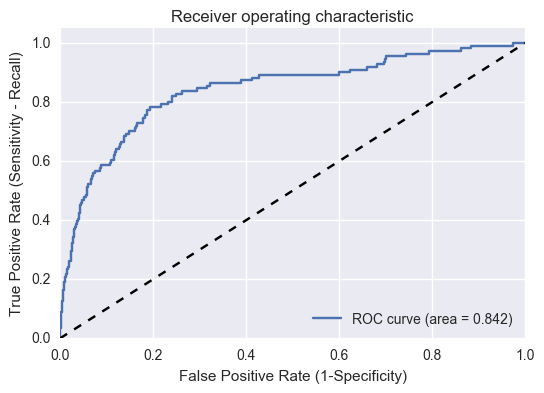

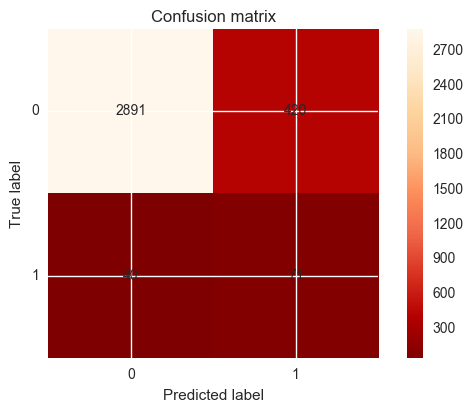

In [15]:
import xgboost

# We start just with a simple one 
model = xgboost.XGBClassifier(scale_pos_weight=list(y_train).count(0)/list(y_train).count(1),
                              n_estimators=100, seed = 123)
# Giving greater weight to get more ones, increase recall
#model = xgboost.XGBClassifier(scale_pos_weight=2*list(y_train).count(0)/list(y_train).count(1))
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

#ml_metrics = tm.basic_train_model(df, model, printing=True)

plot_roc_curve(y_test, model.predict_proba(X_test)[:, 1])
plot_confusion_matrix(metrics.confusion_matrix(y_test, model.predict(X_test)))

print(model)

In [ ]:
#df.iloc[index_test].to_csv('ppp.txt', mode='w', header=True, index=True)
# pd.concat(y_pred, y_test)
s1 = pd.Series(y_test,index=index_test,name='y_test')
s2 = pd.Series(y_pred,index=index_test,name='y_pred')

df["Prediction"] = pd.Series(y_pred,index=index_test,name='y_pred') # Prediction for test

s3 = pd.concat([s1,s2], axis=1)
s4 = pd.concat([df.iloc[index_test],s3],axis=1)

In [ ]:
s4.to_csv('ppp1.txt', mode='w', header=True, index=True)

In [16]:
list(y_train).count(1)

259

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] min_child_weight=5, n_estimators=500, learning_rate=0.05, max_depth=5 
[CV] min_child_weight=5, n_estimators=500, learning_rate=0.05, max_depth=5 
[CV] min_child_weight=5, n_estimators=500, learning_rate=0.05, max_depth=5 
[CV] min_child_weight=10, n_estimators=500, learning_rate=0.05, max_depth=5 
[CV] min_child_weight=10, n_estimators=500, learning_rate=0.05, max_depth=5 
[CV] min_child_weight=25, n_estimators=500, learning_rate=0.05, max_depth=5 
[CV] min_child_weight=10, n_estimators=500, learning_rate=0.05, max_depth=5 
[CV] min_child_weight=25, n_estimators=500, learning_rate=0.05, max_depth=5 
[CV]  min_child_weight=25, n_estimators=500, learning_rate=0.05, max_depth=5, score=0.251497 -  15.9s
[CV] min_child_weight=25, n_estimators=500, learning_rate=0.05, max_depth=5 
[CV]  min_child_weight=25, n_estimators=500, learning_rate=0.05, max_depth=5, score=0.254144 -  16.0s
[CV] min_child_weight=5, n_estimators=500, lea

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   16.3s


[CV]  min_child_weight=10, n_estimators=500, learning_rate=0.05, max_depth=5, score=0.255034 -  16.3s
[CV] min_child_weight=10, n_estimators=500, learning_rate=0.05, max_depth=10 
[CV]  min_child_weight=5, n_estimators=500, learning_rate=0.05, max_depth=5, score=0.273973 -  16.4s
[CV] min_child_weight=10, n_estimators=500, learning_rate=0.05, max_depth=10 
[CV]  min_child_weight=5, n_estimators=500, learning_rate=0.05, max_depth=5, score=0.179104 -  16.4s
[CV]  min_child_weight=5, n_estimators=500, learning_rate=0.05, max_depth=5, score=0.198582 -  16.5s
[CV] min_child_weight=10, n_estimators=500, learning_rate=0.05, max_depth=10 
[CV] min_child_weight=25, n_estimators=500, learning_rate=0.05, max_depth=10 
[CV]  min_child_weight=25, n_estimators=500, learning_rate=0.05, max_depth=5, score=0.270000 -  17.1s
[CV] min_child_weight=25, n_estimators=500, learning_rate=0.05, max_depth=10 
[CV]  min_child_weight=25, n_estimators=500, learning_rate=0.05, max_depth=10, score=0.269231 -  26.3s


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   57.3s finished


{'min_child_weight': 25, 'n_estimators': 500, 'learning_rate': 0.05, 'max_depth': 10}


<module 'matplotlib.pyplot' from '/Users/j.gonzalez/anaconda/envs/python3/lib/python3.5/site-packages/matplotlib/pyplot.py'>

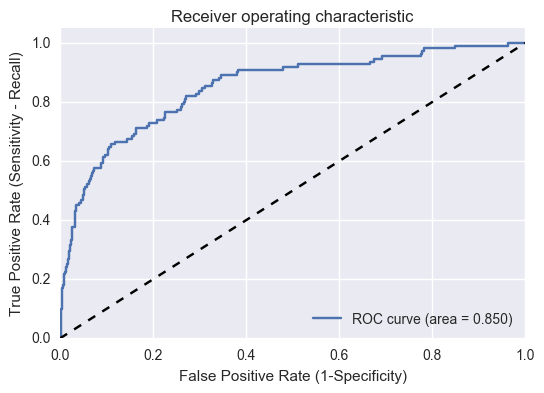

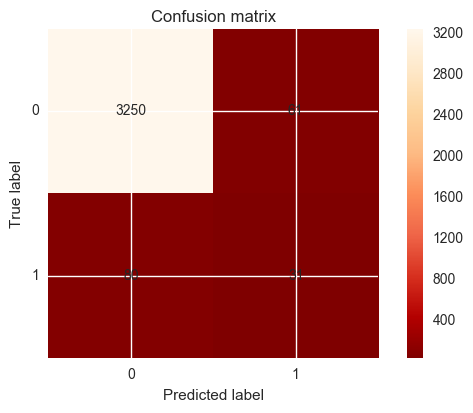

In [17]:
# I add more weight to the 1's to weight the model to find more attritions
model = xgboost.XGBClassifier(scale_pos_weight=list(y_train).count(0)/list(y_train).count(1),seed=123)
gbm_params = {
    #'learning_rate': [0.05, 0.1],
    #'n_estimators': [300, 500],
    #'max_depth': [3, 5, 10],
    'learning_rate': [0.05],
    'n_estimators': [500],
    'max_depth': [5,10],
    'min_child_weight': [5,10,25]
}
cv = StratifiedKFold(y_train)
#grid = GridSearchCV(model, gbm_params,scoring='roc_auc',cv=cv,verbose=10,n_jobs=-1)
grid = GridSearchCV(model, gbm_params,scoring='f1',cv=cv,verbose=10,n_jobs=-1)
#grid.fit(X_train, y_train, sample_weight = )
grid.fit(X_train, y_train)

print (grid.best_params_)

# You can experiment with many other options here, using the same .fit() and .predict()
# methods; see http://scikit-learn.org
# This example uses the current build of XGBoost, from https://github.com/dmlc/xgboost
# gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(train_X, train_y)
y_pred = grid.best_estimator_.predict(X_test)
predictions = [round(value) for value in y_pred]

#ml_metrics = tm.basic_train_model(df, grid.best_estimator_, printing=True)

plot_roc_curve(y_test, grid.best_estimator_.predict_proba(X_test)[:, 1])
plot_confusion_matrix(metrics.confusion_matrix(y_test, grid.best_estimator_.predict(X_test)))

In [ ]:
#print(grid.best_estimator_)
#ml_metrics = tm.basic_train_model(df[variables], grid.best_estimator_, printing=True)

/Users/j.gonzalez/anaconda/envs/python3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


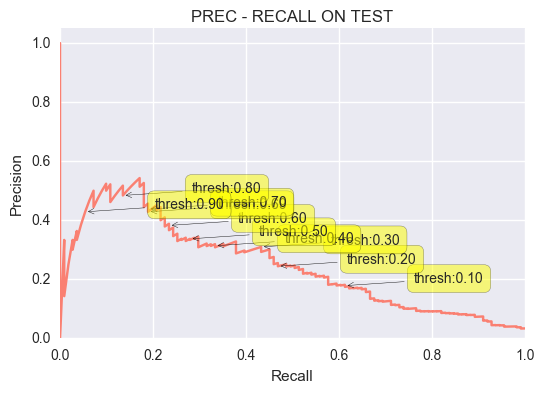

In [18]:
prec, rec, thresholds = metrics.precision_recall_curve(y_test, grid.best_estimator_.predict_proba(X_test)[:, 1]) 
plot_precision_recall_curve(prec, rec, thresholds, 'PREC - RECALL ON TEST')

In [19]:
REGR_EVAL_METRIC = 'rmse'

CLF_EVAL_METRIC = 'auc'
#Refer tuning guide: http://www.slideshare.net/OwenZhang2/tips-for-data-science-competitions
XGB_PARAMS = {
    'n_estimators': [400],
    'max_depth': [4, 6, 8, 10],
    'colsample_bytree': [0.6, 0.8],
    # minimum number of instances in each node for it to be split
    'min_child_weight': [3, 6, 12]
}
XGB_PARAMS_GRID = []
for k in XGB_PARAMS:
    XGB_PARAMS_GRID.append([(k,v) for v in XGB_PARAMS[k]])
XGB_PARAMS_GRID = [dict(x) for x in itertools.product(*XGB_PARAMS_GRID)]
print ('Grid size:',len(XGB_PARAMS_GRID))

Grid size: 24


In [20]:
#X_train, y_train = df_train[FEATURE_COLUMNS_TRAIN], (df_train[DEPENDENT_VARIABLE] > 25)
#X_test, y_test = df_test[FEATURE_COLUMNS_TRAIN], (df_test[DEPENDENT_VARIABLE] > 25)
eval_set = [(X_train, y_train), (X_test, y_test)]
mdl_metrics = []
negative_to_positive_ratio = 1 #default
nrecords = len(y_train)
npos_records = sum(y_train)
if(npos_records !=0):
    negative_to_positive_ratio = (nrecords - npos_records)/npos_records

step = 0
for params in XGB_PARAMS_GRID:
    step += 1
    print ('Step {} of {}'.format(step,len(XGB_PARAMS_GRID)))
    
    #1) Setup an XGBClassifier model
    xgb_classifier_mdl = xgboost.XGBClassifier(
        **params,
        learning_rate=10.0/params['n_estimators'],
        scale_pos_weight=negative_to_positive_ratio,
        nthread=16, 
        seed=172
    )
    
    #2) Fit the model
    xgb_classifier_mdl.fit(
        X_train, 
        y_train,
        eval_metric=CLF_EVAL_METRIC,
        eval_set=eval_set,
        early_stopping_rounds=0.10*params['n_estimators'],
        verbose=False
    )

    #3) Evaluate model training & test errors (for over/under-fitting)
    eval_results = xgb_classifier_mdl.evals_result()
    #plot_train_test_curve(
    #    eval_results, 
    #    CLF_EVAL_METRIC, 
    #    'XGBClassifier - Train vs. Test: {}\n{}'.format('universal',params),
    #    'Epoch', 
    #    CLF_EVAL_METRIC
    #)

    #4) Record model performance (predictions)
    xgb_classifier_y_prediction = xgb_classifier_mdl.predict_proba(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(
        y_test,
        xgb_classifier_y_prediction[:,1],
        pos_label=1
    )
    auc = metrics.auc(fpr, tpr)
    mdl_metrics.append([
            str(params),
            auc
        ])

grid_df = pd.DataFrame([(
                    'XGBClassifier',
                    'universal',
                    X_train.shape[0],
                    g[0], 
                    g[1], 
                ) for g in mdl_metrics],
                columns=['model','aov_band','#instances','params','r_square_or_auc']
            )
#display(grid_df)
grid_df
#grid_df.to_csv(GRIDSEARCH_RESULTS_FILE, mode='a', header=False, index=False)

Step 1 of 24
Step 2 of 24
Step 3 of 24
Step 4 of 24
Step 5 of 24
Step 6 of 24
Step 7 of 24
Step 8 of 24
Step 9 of 24
Step 10 of 24
Step 11 of 24
Step 12 of 24
Step 13 of 24
Step 14 of 24
Step 15 of 24
Step 16 of 24
Step 17 of 24
Step 18 of 24
Step 19 of 24
Step 20 of 24
Step 21 of 24
Step 22 of 24
Step 23 of 24
Step 24 of 24


,model,aov_band,#instances,params,r_square_or_auc
0,XGBClassifier,universal,7982,"{'max_depth': 4, 'min_child_weight': 3, 'n_est...",0.860598
1,XGBClassifier,universal,7982,"{'max_depth': 6, 'min_child_weight': 3, 'n_est...",0.857799
2,XGBClassifier,universal,7982,"{'max_depth': 8, 'min_child_weight': 3, 'n_est...",0.858356
3,XGBClassifier,universal,7982,"{'max_depth': 10, 'min_child_weight': 3, 'n_es...",0.863284
4,XGBClassifier,universal,7982,"{'max_depth': 4, 'min_child_weight': 3, 'n_est...",0.853475
5,XGBClassifier,universal,7982,"{'max_depth': 6, 'min_child_weight': 3, 'n_est...",0.850618
6,XGBClassifier,universal,7982,"{'max_depth': 8, 'min_child_weight': 3, 'n_est...",0.841598
7,XGBClassifier,universal,7982,"{'max_depth': 10, 'min_child_weight': 3, 'n_es...",0.855769
8,XGBClassifier,universal,7982,"{'max_depth': 4, 'min_child_weight': 6, 'n_est...",0.857543
9,XGBClassifier,universal,7982,"{'max_depth': 6, 'min_child_weight': 6, 'n_est...",0.855007


In [ ]:
#grid_df
#mdl_metrics

In [21]:
# From Vatsan utilities
# https://git.soma.salesforce.com/CustomerIntelligence/customer-intelligence-predictor/blob/master/src/utilities.py
def get_optimal_model_params_from_gridsearch(
        model_type, 
        aov_band, 
        grid_df 
        #gridsearch_results_file=GRIDSEARCH_RESULTS_FILE
    ):
    """
        Load the gridsearch results file & return the optimal model parameters
    """
    #gdf = pd.read_csv(GRIDSEARCH_RESULTS_FILE)
    gdf = grid_df
    #defaults
    best_params = {
        'n_estimators': 400,
        'max_depth': 4,
        'colsample_bytree': 1.0,
        # minimum number of instances in each node for it to be split
        'min_child_weight': 1
    }
    
    #if(model_type in set(gdf['model'].values) and aov_band in set(gdf['aov_band'].values)):
    #    filtered_row = gdf[(gdf['model']==model_type) & (gdf['aov_band']==aov_band)]
    filtered_row = gdf
    if(filtered_row.shape[0]>0):
        best_row = gdf.loc[filtered_row['r_square_or_auc'].idxmax()]
        best_params = ast.literal_eval(best_row.to_dict()['params'])
    return best_params

In [22]:
BEST_MDL_PARAMS = get_optimal_model_params_from_gridsearch(model_type='XGBRegressor', aov_band='universal', grid_df=grid_df)

In [23]:
BEST_MDL_PARAMS

{'colsample_bytree': 0.6,
 'max_depth': 10,
 'min_child_weight': 6,
 'n_estimators': 400}

In [24]:
xgb_classifier_mdl.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.025, max_delta_step=0, max_depth=10,
       min_child_weight=12, missing=None, n_estimators=400, nthread=16,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=29.81853281853282, seed=172, silent=True,
       subsample=1)>

<module 'matplotlib.pyplot' from '/Users/j.gonzalez/anaconda/envs/python3/lib/python3.5/site-packages/matplotlib/pyplot.py'>

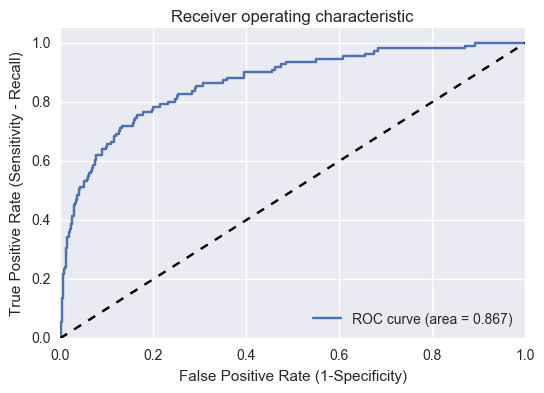

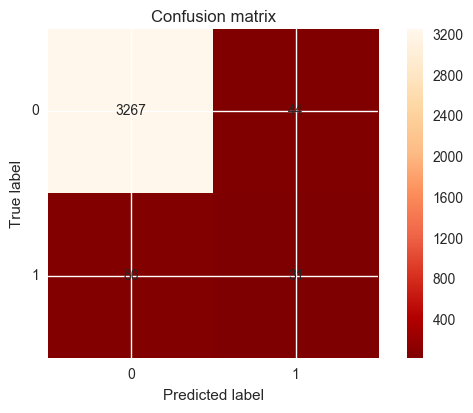

In [26]:
BEST_MDL_PARAMS

xgb_classifier_mdl = xgboost.XGBClassifier(
    **BEST_MDL_PARAMS,
    learning_rate=10.0/params['n_estimators'],
    scale_pos_weight=negative_to_positive_ratio,
    nthread=16, 
    seed=172
)

xgb_classifier_mdl.get_params

model = xgb_classifier_mdl

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

plot_roc_curve(y_test, model.predict_proba(X_test)[:, 1])
plot_confusion_matrix(metrics.confusion_matrix(y_test, model.predict(X_test)))

/Users/j.gonzalez/anaconda/envs/python3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


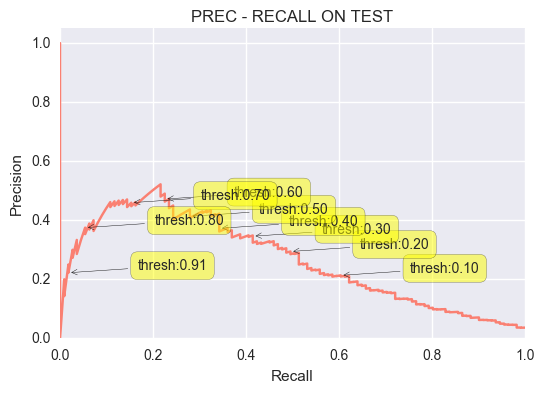

In [27]:
prec, rec, thresholds = metrics.precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1]) 
plot_precision_recall_curve(prec, rec, thresholds, 'PREC - RECALL ON TEST')

[ 0.98339599  0.25217391]
[ 0.94805195  0.52252252]
[ 0.96540058  0.34017595]


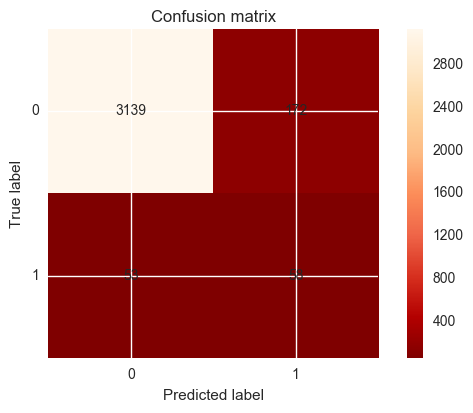

In [28]:
X_prob = model.predict_proba(X_test)[:, 1]

threshold=0.15

predicted_class1=np.zeros(X_prob.shape)
predicted_class1[X_prob>threshold]=1
predicted_class1
plot_confusion_matrix(metrics.confusion_matrix(y_test, predicted_class1))
prec, rec, f1score, support = metrics.precision_recall_fscore_support(y_test, predicted_class1,  pos_label = 1)
print(prec)
print(rec)
print(f1score)

In [49]:
#df.iloc[index_test].to_csv('ppp.txt', mode='w', header=True, index=True)
# pd.concat(y_pred, y_test)
s1 = pd.Series(y_test,index=index_test,name='y_test')
#s2 = pd.Series(y_pred,index=index_test,name='y_pred')
s2 = pd.Series(predicted_class1,index=index_test,name='y_pred') # With modified threshold

#df["Prediction"] = pd.Series(y_pred,index=index_test,name='y_pred') # Prediction for test
s3 = pd.concat([s1,s2], axis=1)
s4 = pd.concat([df.iloc[index_test],s3],axis=1)
#df.iloc[index_test].to_csv('pppxgboost.txt', mode='w', header=True, index=True)
#s3.to_csv('pppxgboost1.txt', mode='w', header=True, index=True)

In [50]:
s4.to_csv('pppxgboost1.csv', mode='w', header=True, index=True)

<module 'matplotlib.pyplot' from '/Users/j.gonzalez/anaconda/envs/python3/lib/python3.5/site-packages/matplotlib/pyplot.py'>

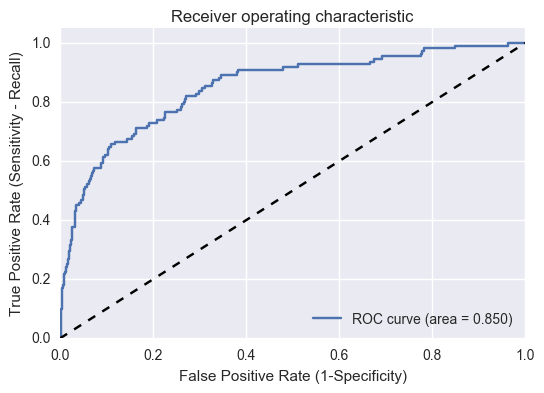

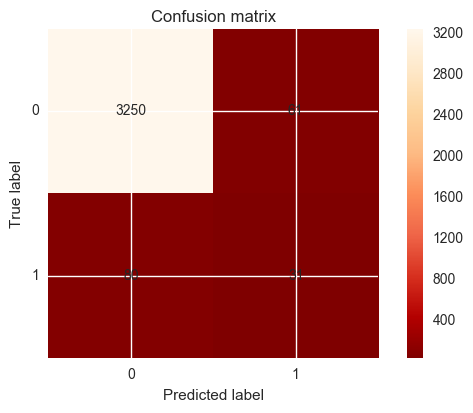

In [51]:
# Best one choose in our grid search
model = grid.best_estimator_

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

#ml_metrics = tm.basic_train_model(df[variables], model, printing=True)

plot_roc_curve(y_test, model.predict_proba(X_test)[:, 1])
plot_confusion_matrix(metrics.confusion_matrix(y_test, model.predict(X_test)))

/Users/j.gonzalez/anaconda/envs/python3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


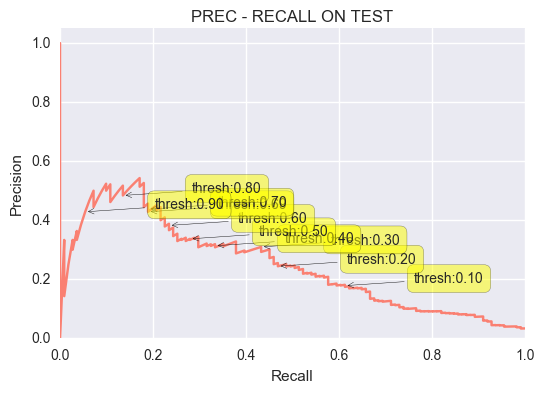

In [52]:
prec, rec, thresholds = metrics.precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1]) 
plot_precision_recall_curve(prec, rec, thresholds, 'PREC - RECALL ON TEST')

[ 0.97760968  0.31623932]
[ 0.97583812  0.33333333]
[ 0.9767231  0.3245614]


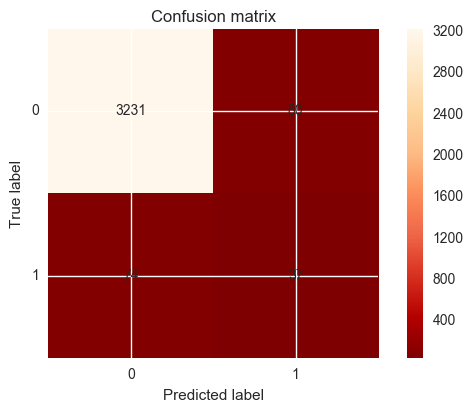

In [54]:
X_prob = model.predict_proba(X_test)[:, 1]

threshold=0.40

predicted_class1=np.zeros(X_prob.shape)
predicted_class1[X_prob>threshold]=1
predicted_class1
plot_confusion_matrix(metrics.confusion_matrix(y_test, predicted_class1))
prec, rec, f1score, support = metrics.precision_recall_fscore_support(y_test, predicted_class1,  pos_label = 1)
print(prec)
print(rec)
print(f1score)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] min_samples_leaf=5, n_estimators=150, max_depth=5 ...............
[CV] min_samples_leaf=5, n_estimators=150, max_depth=5 ...............
[CV] min_samples_leaf=5, n_estimators=150, max_depth=5 ...............
[CV] min_samples_leaf=5, n_estimators=500, max_depth=5 ...............
[CV] min_samples_leaf=5, n_estimators=500, max_depth=5 ...............
[CV] min_samples_leaf=5, n_estimators=500, max_depth=5 ...............
[CV] min_samples_leaf=10, n_estimators=150, max_depth=5 ..............
[CV] min_samples_leaf=10, n_estimators=150, max_depth=5 ..............
[CV]  min_samples_leaf=5, n_estimators=150, max_depth=5, score=0.832290 -   1.6s
[CV]  min_samples_leaf=5, n_estimators=150, max_depth=5, score=0.810751 -   1.7s
[CV] min_samples_leaf=10, n_estimators=150, max_depth=5 ..............
[CV]  min_samples_leaf=5, n_estimators=150, max_depth=5, score=0.869577 -   1.7s
[CV] min_samples_leaf=10, n_estimators=500, max_depth=5 .

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.7s


[CV]  min_samples_leaf=10, n_estimators=150, max_depth=5, score=0.830849 -   1.7s
[CV] min_samples_leaf=25, n_estimators=150, max_depth=5 ..............
[CV]  min_samples_leaf=25, n_estimators=150, max_depth=5, score=0.870501 -   1.6s
[CV] min_samples_leaf=25, n_estimators=150, max_depth=5 ..............
[CV]  min_samples_leaf=25, n_estimators=150, max_depth=5, score=0.810809 -   1.7s
[CV] min_samples_leaf=25, n_estimators=500, max_depth=5 ..............
[CV]  min_samples_leaf=25, n_estimators=150, max_depth=5, score=0.830356 -   1.7s
[CV] min_samples_leaf=25, n_estimators=500, max_depth=5 ..............


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.3s


[CV]  min_samples_leaf=5, n_estimators=500, max_depth=5, score=0.811975 -   5.8s
[CV]  min_samples_leaf=5, n_estimators=500, max_depth=5, score=0.832687 -   5.8s
[CV] min_samples_leaf=5, n_estimators=150, max_depth=10 ..............
[CV] min_samples_leaf=25, n_estimators=500, max_depth=5 ..............
[CV]  min_samples_leaf=5, n_estimators=500, max_depth=5, score=0.872086 -   5.9s
[CV] min_samples_leaf=5, n_estimators=150, max_depth=10 ..............
[CV]  min_samples_leaf=10, n_estimators=500, max_depth=5, score=0.873206 -   5.9s
[CV] min_samples_leaf=5, n_estimators=150, max_depth=10 ..............
[CV]  min_samples_leaf=10, n_estimators=500, max_depth=5, score=0.832118 -   6.0s
[CV] min_samples_leaf=5, n_estimators=500, max_depth=10 ..............
[CV]  min_samples_leaf=10, n_estimators=500, max_depth=5, score=0.811347 -   6.2s
[CV] min_samples_leaf=5, n_estimators=500, max_depth=10 ..............
[CV]  min_samples_leaf=5, n_estimators=150, max_depth=10, score=0.873536 -   2.6s
[CV

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    8.5s


[CV]  min_samples_leaf=5, n_estimators=150, max_depth=10, score=0.827126 -   2.6s
[CV] min_samples_leaf=10, n_estimators=150, max_depth=10 .............
[CV]  min_samples_leaf=10, n_estimators=150, max_depth=10, score=0.871340 -   2.5s
[CV] min_samples_leaf=10, n_estimators=150, max_depth=10 .............
[CV]  min_samples_leaf=25, n_estimators=500, max_depth=5, score=0.873153 -   6.3s
[CV] min_samples_leaf=10, n_estimators=500, max_depth=10 .............
[CV]  min_samples_leaf=25, n_estimators=500, max_depth=5, score=0.810421 -   6.4s
[CV] min_samples_leaf=10, n_estimators=500, max_depth=10 .............
[CV]  min_samples_leaf=25, n_estimators=500, max_depth=5, score=0.831788 -   6.5s
[CV] min_samples_leaf=10, n_estimators=500, max_depth=10 .............
[CV]  min_samples_leaf=10, n_estimators=150, max_depth=10, score=0.810710 -   2.6s
[CV] min_samples_leaf=25, n_estimators=150, max_depth=10 .............
[CV]  min_samples_leaf=10, n_estimators=150, max_depth=10, score=0.827858 -   2.

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.4s


[CV]  min_samples_leaf=25, n_estimators=150, max_depth=10, score=0.811722 -   2.5s
[CV] min_samples_leaf=25, n_estimators=500, max_depth=10 .............
[CV]  min_samples_leaf=5, n_estimators=500, max_depth=10, score=0.815313 -   9.0s
[CV] min_samples_leaf=25, n_estimators=500, max_depth=10 .............
[CV]  min_samples_leaf=5, n_estimators=500, max_depth=10, score=0.872876 -   9.2s
[CV] min_samples_leaf=25, n_estimators=500, max_depth=10 .............
[CV]  min_samples_leaf=5, n_estimators=500, max_depth=10, score=0.839242 -   9.2s
[CV] min_samples_leaf=5, n_estimators=150, max_depth=15 ..............
[CV]  min_samples_leaf=25, n_estimators=150, max_depth=10, score=0.828879 -   2.8s
[CV] min_samples_leaf=5, n_estimators=150, max_depth=15 ..............
[CV]  min_samples_leaf=5, n_estimators=150, max_depth=15, score=0.877657 -   2.7s
[CV] min_samples_leaf=5, n_estimators=150, max_depth=15 ..............
[CV]  min_samples_leaf=10, n_estimators=500, max_depth=10, score=0.877344 -   9.

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   21.0s


[CV]  min_samples_leaf=10, n_estimators=500, max_depth=10, score=0.832199 -   8.9s
[CV] min_samples_leaf=10, n_estimators=150, max_depth=15 .............
[CV]  min_samples_leaf=5, n_estimators=150, max_depth=15, score=0.826178 -   2.7s
[CV] min_samples_leaf=10, n_estimators=150, max_depth=15 .............
[CV]  min_samples_leaf=10, n_estimators=150, max_depth=15, score=0.876237 -   2.5s
[CV] min_samples_leaf=10, n_estimators=150, max_depth=15 .............
[CV]  min_samples_leaf=25, n_estimators=500, max_depth=10, score=0.870247 -   8.4s
[CV] min_samples_leaf=10, n_estimators=500, max_depth=15 .............
[CV]  min_samples_leaf=25, n_estimators=500, max_depth=10, score=0.814387 -   8.1s
[CV] min_samples_leaf=10, n_estimators=500, max_depth=15 .............
[CV]  min_samples_leaf=25, n_estimators=500, max_depth=10, score=0.829227 -   8.1s
[CV] min_samples_leaf=10, n_estimators=500, max_depth=15 .............
[CV]  min_samples_leaf=10, n_estimators=150, max_depth=15, score=0.808474 -  

[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   35.3s finished


{'min_samples_leaf': 5, 'n_estimators': 500, 'max_depth': 10}


<module 'matplotlib.pyplot' from '/Users/j.gonzalez/anaconda/envs/python3/lib/python3.5/site-packages/matplotlib/pyplot.py'>

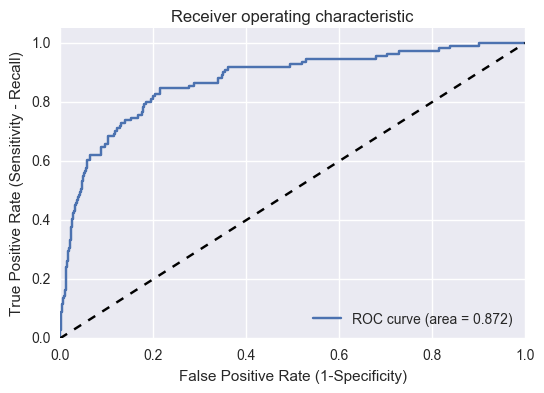

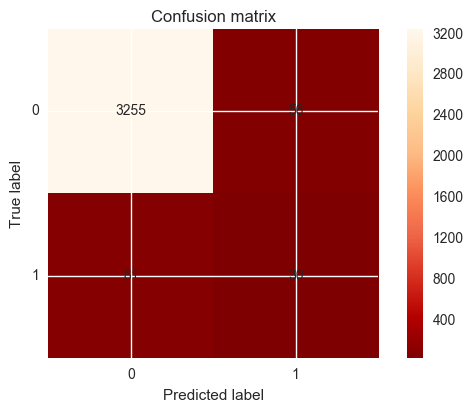

In [55]:
# Grid search for parameters in RF
model = ensemble.RandomForestClassifier(
    #n_estimators = 20,
    #max_depth = 8,
    #min_samples_leaf = 5,
    class_weight = "balanced_subsample",
    random_state = 72
)

rf_params = {
    'n_estimators': [150, 500],
    'max_depth': [5, 10, 15],
    'min_samples_leaf': [5, 10, 25],
}

cv = StratifiedKFold(y_train)
gridRF = GridSearchCV(model, rf_params,scoring='roc_auc',cv=cv,verbose=10,n_jobs=-1)
gridRF.fit(X_train, y_train)

print (gridRF.best_params_)

# You can experiment with many other options here, using the same .fit() and .predict()
# methods; see http://scikit-learn.org
# This example uses the current build of XGBoost, from https://github.com/dmlc/xgboost
# gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(train_X, train_y)
y_pred = gridRF.best_estimator_.predict(X_test)
predictions = [round(value) for value in y_pred]

#ml_metrics = tm.basic_train_model(df[variables], gridRF.best_estimator_, printing=True)

plot_roc_curve(y_test, gridRF.best_estimator_.predict_proba(X_test)[:, 1])
plot_confusion_matrix(metrics.confusion_matrix(y_test, gridRF.best_estimator_.predict(X_test)))

/Users/j.gonzalez/anaconda/envs/python3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


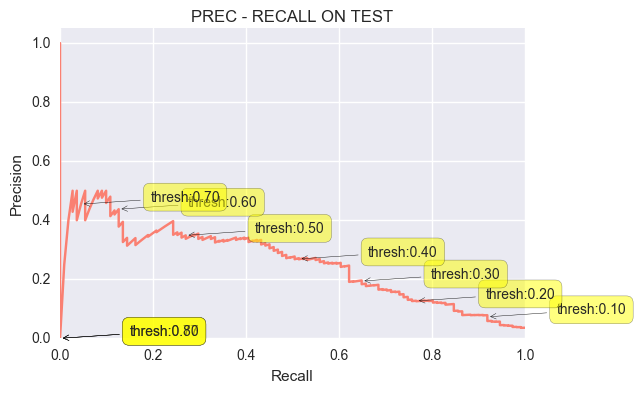

In [56]:
prec, rec, thresholds = metrics.precision_recall_curve(y_test, gridRF.best_estimator_.predict_proba(X_test)[:, 1]) 
plot_precision_recall_curve(prec, rec, thresholds, 'PREC - RECALL ON TEST')

[ 0.98661994  0.24381625]
[ 0.93536696  0.62162162]
[ 0.96031008  0.35025381]


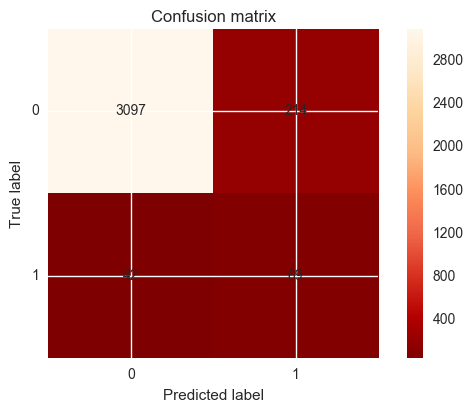

In [57]:
X_prob = gridRF.best_estimator_.predict_proba(X_test)[:, 1]

threshold=0.35

predicted_class1=np.zeros(X_prob.shape)
predicted_class1[X_prob>threshold]=1
predicted_class1
plot_confusion_matrix(metrics.confusion_matrix(y_test, predicted_class1))
prec, rec, f1score, support = metrics.precision_recall_fscore_support(y_test, predicted_class1,  pos_label = 1)
print(prec)
print(rec)
print(f1score)

In [58]:
print (gridRF.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=72, verbose=0, warm_start=False)


Training: 7982 rows
Testing: 3422 rows
Fit in 6.55 s
Accuracy: 0.9573
F1:       0.2551
AUC:       0.8812


<module 'matplotlib.pyplot' from '/Users/j.gonzalez/anaconda/envs/python3/lib/python3.5/site-packages/matplotlib/pyplot.py'>

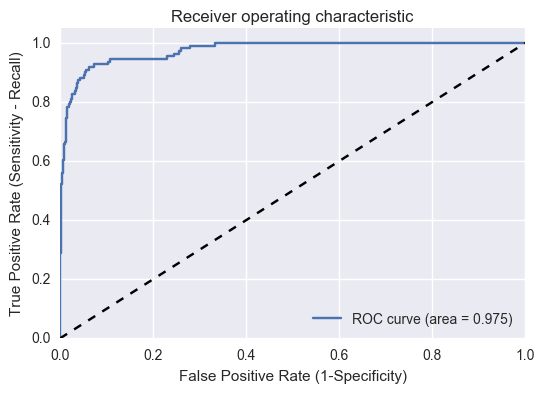

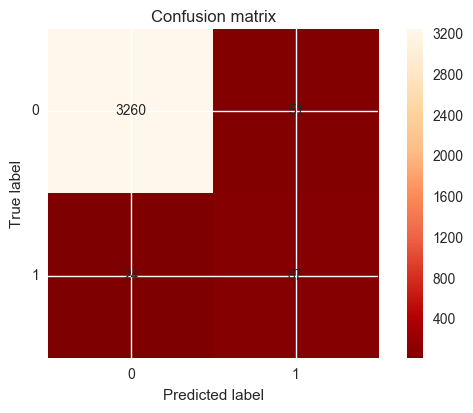

In [59]:
y_pred = gridRF.best_estimator_.predict(X_test)
predictions = [round(value) for value in y_pred]

ml_metrics = tm.basic_train_model(df[variables], gridRF.best_estimator_, printing=True)

plot_roc_curve(y_test, gridRF.best_estimator_.predict_proba(X_test)[:, 1])
plot_confusion_matrix(metrics.confusion_matrix(y_test, gridRF.best_estimator_.predict(X_test)))

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] min_samples_leaf=5, n_estimators=150, max_depth=5 ...............
[CV] min_samples_leaf=5, n_estimators=150, max_depth=5 ...............
[CV] min_samples_leaf=5, n_estimators=150, max_depth=5 ...............
[CV] min_samples_leaf=5, n_estimators=500, max_depth=5 ...............
[CV] min_samples_leaf=5, n_estimators=500, max_depth=5 ...............
[CV] min_samples_leaf=5, n_estimators=500, max_depth=5 ...............
[CV] min_samples_leaf=10, n_estimators=150, max_depth=5 ..............
[CV] min_samples_leaf=10, n_estimators=150, max_depth=5 ..............
[CV]  min_samples_leaf=5, n_estimators=150, max_depth=5, score=0.269006 -   1.7s
[CV] min_samples_leaf=10, n_estimators=150, max_depth=5 ..............
[CV]  min_samples_leaf=5, n_estimators=150, max_depth=5, score=0.247887 -   1.7s
[CV] min_samples_leaf=10, n_estimators=500, max_depth=5 ..............
[CV]  min_samples_leaf=5, n_estimators=150, max_depth=5, score=0.24

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.8s


[CV]  min_samples_leaf=10, n_estimators=150, max_depth=5, score=0.243655 -   1.8s
[CV] min_samples_leaf=25, n_estimators=150, max_depth=5 ..............
[CV]  min_samples_leaf=25, n_estimators=150, max_depth=5, score=0.276382 -   1.7s
[CV] min_samples_leaf=25, n_estimators=150, max_depth=5 ..............
[CV]  min_samples_leaf=25, n_estimators=150, max_depth=5, score=0.239796 -   1.8s
[CV] min_samples_leaf=25, n_estimators=500, max_depth=5 ..............
[CV]  min_samples_leaf=25, n_estimators=150, max_depth=5, score=0.223214 -   1.8s
[CV] min_samples_leaf=25, n_estimators=500, max_depth=5 ..............


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.5s


[CV]  min_samples_leaf=5, n_estimators=500, max_depth=5, score=0.272727 -   6.0s
[CV] min_samples_leaf=25, n_estimators=500, max_depth=5 ..............
[CV]  min_samples_leaf=5, n_estimators=500, max_depth=5, score=0.238889 -   6.1s
[CV] min_samples_leaf=5, n_estimators=150, max_depth=10 ..............
[CV]  min_samples_leaf=5, n_estimators=500, max_depth=5, score=0.251928 -   6.1s
[CV] min_samples_leaf=5, n_estimators=150, max_depth=10 ..............
[CV]  min_samples_leaf=10, n_estimators=500, max_depth=5, score=0.235955 -   6.0s
[CV]  min_samples_leaf=10, n_estimators=500, max_depth=5, score=0.277929 -   6.0s
[CV] min_samples_leaf=5, n_estimators=150, max_depth=10 ..............
[CV] min_samples_leaf=5, n_estimators=500, max_depth=10 ..............
[CV]  min_samples_leaf=10, n_estimators=500, max_depth=5, score=0.246154 -   6.1s
[CV] min_samples_leaf=5, n_estimators=500, max_depth=10 ..............
[CV]  min_samples_leaf=5, n_estimators=150, max_depth=10, score=0.212766 -   2.5s
[CV

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    8.7s


[CV]  min_samples_leaf=5, n_estimators=150, max_depth=10, score=0.181818 -   2.5s
[CV] min_samples_leaf=10, n_estimators=150, max_depth=10 .............
[CV]  min_samples_leaf=10, n_estimators=150, max_depth=10, score=0.242775 -   2.4s
[CV] min_samples_leaf=10, n_estimators=150, max_depth=10 .............
[CV]  min_samples_leaf=25, n_estimators=500, max_depth=5, score=0.274510 -   6.0s
[CV] min_samples_leaf=10, n_estimators=500, max_depth=10 .............
[CV]  min_samples_leaf=25, n_estimators=500, max_depth=5, score=0.232911 -   6.0s
[CV] min_samples_leaf=10, n_estimators=500, max_depth=10 .............
[CV]  min_samples_leaf=25, n_estimators=500, max_depth=5, score=0.229213 -   6.1s
[CV] min_samples_leaf=10, n_estimators=500, max_depth=10 .............
[CV]  min_samples_leaf=10, n_estimators=150, max_depth=10, score=0.245614 -   2.4s
[CV] min_samples_leaf=25, n_estimators=150, max_depth=10 .............
[CV]  min_samples_leaf=10, n_estimators=150, max_depth=10, score=0.282353 -   2.

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.1s


[CV]  min_samples_leaf=25, n_estimators=150, max_depth=10, score=0.255034 -   2.3s
[CV] min_samples_leaf=25, n_estimators=500, max_depth=10 .............
[CV]  min_samples_leaf=5, n_estimators=500, max_depth=10, score=0.205882 -   8.4s
[CV] min_samples_leaf=25, n_estimators=500, max_depth=10 .............
[CV]  min_samples_leaf=5, n_estimators=500, max_depth=10, score=0.195489 -   8.3s
[CV] min_samples_leaf=25, n_estimators=500, max_depth=10 .............
[CV]  min_samples_leaf=5, n_estimators=500, max_depth=10, score=0.187500 -   8.5s
[CV] min_samples_leaf=5, n_estimators=150, max_depth=15 ..............
[CV]  min_samples_leaf=25, n_estimators=150, max_depth=10, score=0.283019 -   2.4s
[CV] min_samples_leaf=5, n_estimators=150, max_depth=15 ..............
[CV]  min_samples_leaf=10, n_estimators=500, max_depth=10, score=0.265896 -   8.4s
[CV] min_samples_leaf=5, n_estimators=150, max_depth=15 ..............
[CV]  min_samples_leaf=10, n_estimators=500, max_depth=10, score=0.258427 -   8

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.1s


[CV]  min_samples_leaf=10, n_estimators=500, max_depth=10, score=0.290698 -   8.2s
[CV] min_samples_leaf=10, n_estimators=150, max_depth=15 .............
[CV]  min_samples_leaf=5, n_estimators=150, max_depth=15, score=0.080000 -   2.7s
[CV] min_samples_leaf=10, n_estimators=150, max_depth=15 .............
[CV]  min_samples_leaf=10, n_estimators=150, max_depth=15, score=0.246753 -   2.6s
[CV] min_samples_leaf=10, n_estimators=150, max_depth=15 .............
[CV]  min_samples_leaf=25, n_estimators=500, max_depth=10, score=0.290780 -   7.9s
[CV] min_samples_leaf=10, n_estimators=500, max_depth=15 .............
[CV]  min_samples_leaf=25, n_estimators=500, max_depth=10, score=0.251656 -   7.8s
[CV] min_samples_leaf=10, n_estimators=500, max_depth=15 .............
[CV]  min_samples_leaf=25, n_estimators=500, max_depth=10, score=0.287582 -   7.8s
[CV] min_samples_leaf=10, n_estimators=500, max_depth=15 .............
[CV]  min_samples_leaf=10, n_estimators=150, max_depth=15, score=0.226415 -  

[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   34.2s finished


{'min_samples_leaf': 25, 'n_estimators': 500, 'max_depth': 15}
Training: 7982 rows
Testing: 3422 rows
Fit in 5.97 s
Accuracy: 0.9249
F1:       0.2920
AUC:       0.8759


<module 'matplotlib.pyplot' from '/Users/j.gonzalez/anaconda/envs/python3/lib/python3.5/site-packages/matplotlib/pyplot.py'>

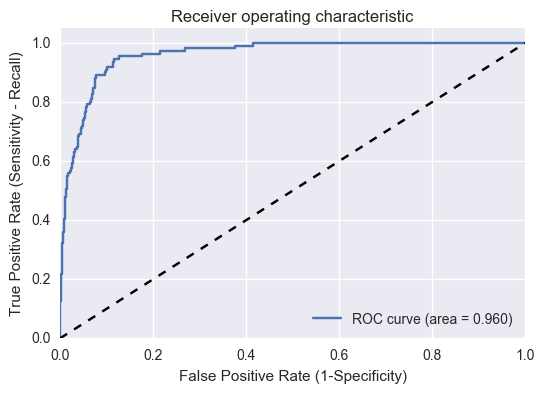

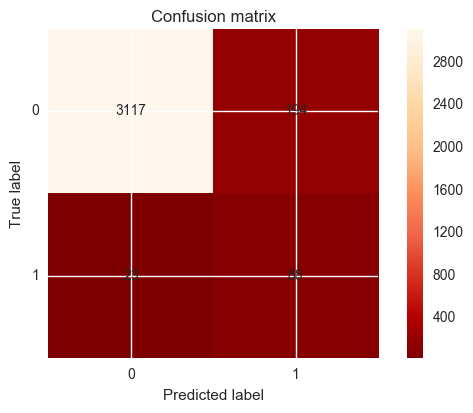

In [60]:
# Grid search for parameters in RF
model = ensemble.RandomForestClassifier(
    #n_estimators = 20,
    #max_depth = 8,
    #min_samples_leaf = 5,
    class_weight = "balanced_subsample",
    random_state = 72
)

rf_params = {
    'n_estimators': [150, 500],
    'max_depth': [5, 10, 15],
    'min_samples_leaf': [5, 10, 25],
}

# We are going to optimize in f1
cv = StratifiedKFold(y_train)
gridRF = GridSearchCV(model, rf_params,scoring='f1',cv=cv,verbose=10,n_jobs=-1)
gridRF.fit(X_train, y_train)

print (gridRF.best_params_)

# You can experiment with many other options here, using the same .fit() and .predict()
# methods; see http://scikit-learn.org
# This example uses the current build of XGBoost, from https://github.com/dmlc/xgboost
# gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(train_X, train_y)
y_pred = gridRF.best_estimator_.predict(X_test)
predictions = [round(value) for value in y_pred]

ml_metrics = tm.basic_train_model(df[variables], gridRF.best_estimator_, printing=True)

plot_roc_curve(y_test, gridRF.best_estimator_.predict_proba(X_test)[:, 1])
plot_confusion_matrix(metrics.confusion_matrix(y_test, gridRF.best_estimator_.predict(X_test)))

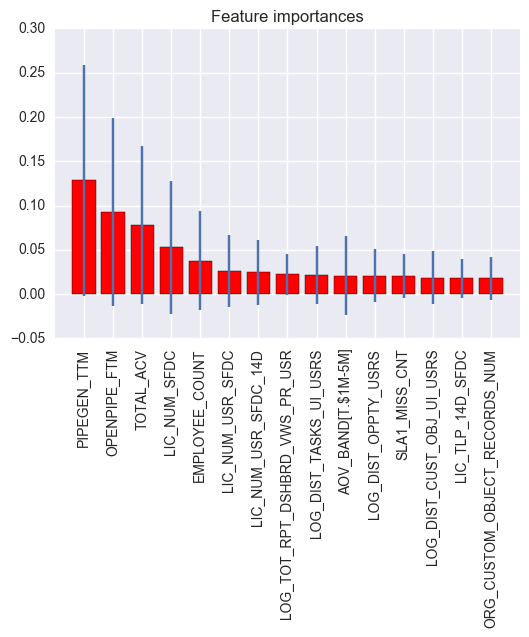

In [69]:
model = gridRF.best_estimator_

importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
#print("Feature ranking:")
#for f in range(X.shape[1]):
#    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

toptoplot = 15

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(toptoplot), importances[indices][0:toptoplot], color="r", yerr=std[indices][0:toptoplot], align="center")
plt.xticks(range(toptoplot), feature_names[list(indices[0:toptoplot])], rotation='vertical')
plt.xlim([-1, toptoplot])
plt.show()


In [62]:
# Best one choose in our grid search
model = grid.best_estimator_
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=10,
       min_child_weight=25, missing=None, n_estimators=500, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=29.81853281853282, seed=123, silent=True,
       subsample=1)

In [63]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

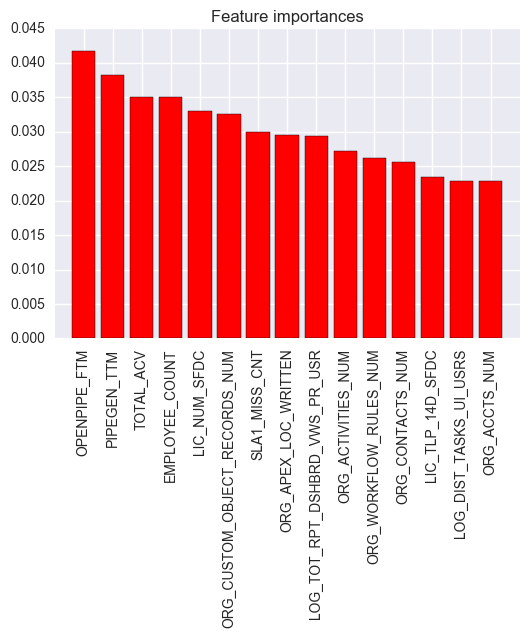

In [64]:
importances = model.feature_importances_
#std = np.std([tree.feature_importances_ for tree in model.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
# Plot the feature importances of the forest
toptoplot = 15
plt.figure()
plt.title("Feature importances")
plt.bar(range(toptoplot), importances[indices][0:toptoplot], color="r", align="center")
plt.xticks(range(toptoplot), feature_names[list(indices[0:toptoplot])], rotation='vertical')
plt.xlim([-1, toptoplot])
plt.show()


In [70]:
#X_prob = model.predict_proba(X_test)[:, 1]
#X_prob = gridRF.best_estimator_.predict_proba(X_test)[:, 1]
X_prob = grid.best_estimator_.predict_proba(X_test)[:, 1]

[ 0.98116703  0.27322404]
[ 0.95983087  0.45045045]
[ 0.97038168  0.34013605]


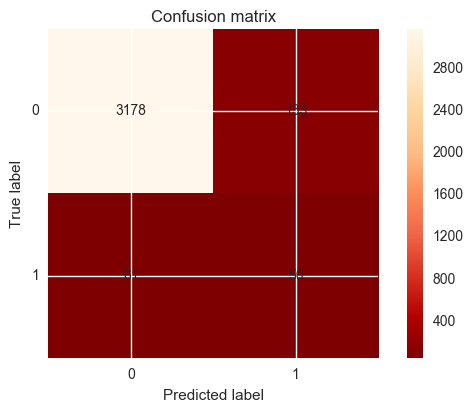

In [71]:
threshold=0.25

predicted_class1=np.zeros(X_prob.shape)
predicted_class1[X_prob>threshold]=1
predicted_class1
plot_confusion_matrix(metrics.confusion_matrix(y_test, predicted_class1))
prec, rec, f1score, support = metrics.precision_recall_fscore_support(y_test, predicted_class1,  pos_label = 1)
print(prec)
print(rec)
print(f1score)

In [73]:
#plot_confusion_matrix(metrics.confusion_matrix(y_test, grid.best_estimator_.predict(X_test)))
#plot_confusion_matrix(metrics.confusion_matrix(y_test, grid.best_estimator_.predict_proba(X_test)))

/Users/j.gonzalez/anaconda/envs/python3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


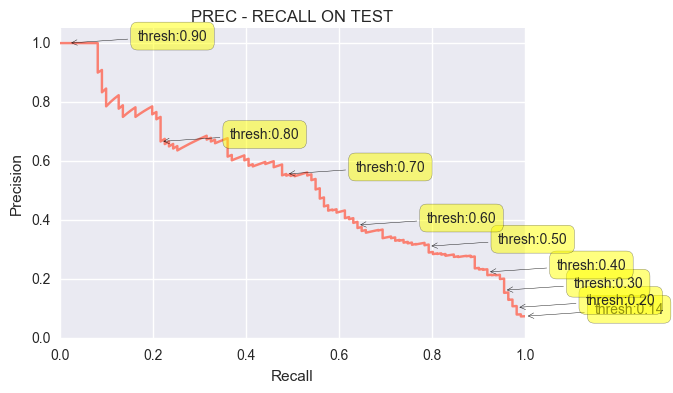

In [74]:
#prec, rec, thresholds = metrics.precision_recall_curve(y_test, grid.best_estimator_.predict_proba(X_test)[:, 1]) 
prec, rec, thresholds = metrics.precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1]) 
plot_precision_recall_curve(prec, rec, thresholds, 'PREC - RECALL ON TEST')